# Qlib：模型训练篇

In [1]:
import qlib
from qlib.constant import REG_CN
data_uri = '****'
qlib.init(provider_uri=data_uri, region=REG_CN)

[15248:MainThread](2022-05-12 00:05:24,815) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[15248:MainThread](2022-05-12 00:05:25,364) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[15248:MainThread](2022-05-12 00:05:25,365) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/Users/lusong/.qlib/qlib_data/cn_data_wind')}


# 通过config实例化操作

我们在上一篇介绍了qlib中数据相关的模块，使用这些模块，我们就能读取数据-处理数据-计算特征。在需要使用Data Loader、Data Handler或Dataset的时候，我们可以直接使用“配置”的方式进行实例化。看下面的实例，比如我们要实例化一个QlibDataLoader：

* "class": 指定需要实例化的类，
* "module_path": str格式, 表明该类的路径；
* "kwargs": "class"初始化的参数；
* init_instance_by_config: 根据“配置”进行类实例化的函数。

In [27]:
from qlib.utils import init_instance_by_config

qdl_config = {
    "class": "QlibDataLoader",
    "module_path": "qlib.data.dataset.loader",
    "kwargs": {
        "config": {
            "feature": (['EMA($close, 10)', 'EMA($close, 30)'], ['EMA10', 'EMA30'] ),
            "label": (['Ref($close, -1)/$close - 1',],['RET_1',]),
        },
        "freq": 'day',
    },
}

# 以下这种写法也可以，注意class/module_path和上面的区别，这里没有module_path
# qdl_config = {
#     "class": "qlib.data.dataset.loader.QlibDataLoader",
#     "kwargs": {
#         "config": {
#             "feature": (['EMA($close, 10)', 'EMA($close, 30)'], ['EMA10', 'EMA30'] ),
#             "label": (['Ref($close, -1)/$close - 1',],['RET_1',]),
#         },
#         "freq": 'day',
#         # "inst_processor": inst_processor,
#     },
# }


qdl = init_instance_by_config(qdl_config)

In [28]:
market = 'sh000300' # 沪深300股票池代码，在instruments文件夹下有对应的sh000300.txt
qdl.load(instruments=market, start_time='20210101', end_time='20210110')

feature                 label
                            EMA10       EMA30     RET_1
datetime   instrument                                  
2021-01-04 SH600000    128.776688  130.428864 -0.001001
           SH600004     35.711178   36.639740 -0.016393
           SH600009    227.689270  231.307571 -0.002437
           SH600010      9.757089    9.815779 -0.008138
           SH600011     21.803612   22.311543 -0.022326
...                           ...         ...       ...
2021-01-08 SZ300498     38.268608   38.167015 -0.039302
           SZ300529    146.323364  141.267807 -0.047604
           SZ300601    252.086090  247.119064 -0.062272
           SZ300628    906.532104  892.788696 -0.009128
           SZ300676    134.093430  132.403580  0.053332

[1500 rows x 3 columns]

对于一些常用的因子或特征，我们可以写成一个继承自DataHandlerLP的类，以便后面重复调用。接下来，我们就以MACD和RSI两个指标为例，实现一个自定义DataHandlerLP的类。

In [50]:
# 实现一个自定义的特征集，MACD、RSI

from qlib.data.dataset.handler import DataHandlerLP

class MyFeatureSet(DataHandlerLP):
    def __init__(self,
                 instruments="sh000300", 
                 start_time=None,
                 end_time=None,
                 freq="day",
                 infer_processors=[],
                 learn_processors=[],
                 fit_start_time=None,
                 fit_end_time=None,
                 process_type=DataHandlerLP.PTYPE_A,
                 filter_pipe=None,
                 inst_processor=None,
                 **kwargs,
                ):
        data_loader = {
            "class": "QlibDataLoader",
            "kwargs": {
                "config": {
                    "feature": self.get_feature_config(),
                    "label": kwargs.get("label", self.get_label_config()), # label可以自定义，也可以使用初始化时候的设置
                },
                "filter_pipe": filter_pipe,
                "freq": freq,
                "inst_processor": inst_processor,
                },
            }
        super().__init__(
            instruments=instruments,
            start_time=start_time,
            end_time=end_time,
            data_loader=data_loader,
            infer_processors=infer_processors,
            learn_processors=learn_processors,
            process_type=process_type,
        )

        
    def get_feature_config(self):
        
        MACD = '(EMA($close, 12) - EMA($close, 26))/$close - EMA((EMA($close, 12) - EMA($close, 26))/$close, 9)/$close'
        RSI = '100 - 100/(1+(Sum(Greater($close-Ref($close, 1),0), 14)/Count(($close-Ref($close, 1))>0, 14))/ (Sum(Abs(Greater(Ref($close, 1)-$close,0)), 14)/Count(($close-Ref($close, 1))<0, 14)))'
        
        return [MACD, RSI ], ['MACD', 'RSI']

    def get_label_config(self):
        return (["Ref($close, -1)/$close - 1"], ["LABEL"])


# 初始化的过程中已经完成的数据的load
my_feature = MyFeatureSet(instruments='sh000300', start_time='2021-01-01', end_time='2021-06-30')

# my_feature.get_feature_config()

In [48]:
my_feature.fetch()  # my_feature.fetch(col_set='feature') /   my_feature.fetch(col_set='label')

MACD        RSI    LABEL0
datetime   instrument                               
2021-01-04 SH600000   -0.007186  45.913155 -0.001001
           SH600004   -0.015663  46.293892 -0.016393
           SH600009   -0.010205  53.609177 -0.002437
           SH600010   -0.003703  53.773582 -0.008138
           SH600011   -0.016717  45.873322 -0.022326
...                         ...        ...       ...
2021-06-30 SZ300595    0.030738  45.324696  0.013999
           SZ300601   -0.040844  37.733463  0.007725
           SZ300628    0.028161  57.792118 -0.009541
           SZ300676   -0.012797  38.569992 -0.019409
           SZ300677   -0.035194  77.440514 -0.022445

[35400 rows x 3 columns]

实际上qlib内部也提供了两个特征集：Alpha158和Alpha360:

* Alpha158
* Alpha360

处理数据过程中，可以自定义infer_processors和learn_processors.

# 准备数据及模型，进行训练

在Qlib的框架下，使用机器学习进行量化研究主要有以下步骤：
* 数据准备 Dataset
* 模型配置 
* 训练及结果分析

我们之前的数据篇已经完成了数据准备的部分，这其中的核心就是因子（或指标），当然我们可以先使用内置的Alpha158或Alpha360。关于模型的准备及实现，主要分为两个部分，首先是借助常用的机器学习或深度学习框架（推荐Pytorch）实现预测模型，然后再继承qlib.model.base.Model，实现模型的训练和测试过程。这两部分我们后面会结合源码给大家更详细的解释。

Qlib之所以受欢迎，很大程度是因为其本身已经实现了大量的模型。具体实现的模型可以在qlib.contrib.model，顺便说一下qlib.contrib这个子模块主要都是基于qlib核心模块实现的一些便利性功能，比如Alpha158就是qlib.contrib.data.handler路径下。

接下来我们使用Alpha158数据集，及内置ALSTM模型，说明一下模型训练的过程。（由于时间原因，并没用运行至结束）

In [56]:
from qlib.contrib.data.handler import Alpha158
from qlib.data.dataset import TSDatasetH
from qlib.contrib.model.pytorch_alstm_ts import ALSTM

# 配置数据
train_period = ("2015-01-01", "2019-12-31")
valid_period = ("2020-01-01", "2020-12-31")
test_period = ("2021-01-01", "2022-03-01")

dh = Alpha158(instruments='sh000300', 
              start_time=train_period[0], 
              end_time=test_period[1],
              infer_processors={}
              
             )
ds = TSDatasetH(handler=dh,
                step_len=40, # 时间步数
                segments={"train": train_period, 
                          "valid": valid_period, 
                          "test": test_period})

# 配置模型
model = ALSTM(d_feat=158, 
              metric='mse', 
              rnn_type='GRU', 
              batch_size=800, 
              early_stop=10) # 其他参数使用默认设置


# 模型训练, 使用fit方法
model.fit(dataset=ds,
          save_path=None)  # 保存模型的路径，默认存在当前路径


[15248:MainThread](2022-05-12 15:58:28,724) INFO - qlib.timer - [log.py:113] - Time cost: 50.095s | Loading data Done
[15248:MainThread](2022-05-12 15:58:29,611) INFO - qlib.timer - [log.py:113] - Time cost: 0.244s | DropnaLabel Done
[15248:MainThread](2022-05-12 15:58:32,085) INFO - qlib.timer - [log.py:113] - Time cost: 2.473s | CSZScoreNorm Done
[15248:MainThread](2022-05-12 15:58:32,086) INFO - qlib.timer - [log.py:113] - Time cost: 3.359s | fit & process data Done
[15248:MainThread](2022-05-12 15:58:32,087) INFO - qlib.timer - [log.py:113] - Time cost: 53.459s | Init data Done
[15248:MainThread](2022-05-12 15:58:32,210) INFO - qlib.ALSTM - [pytorch_alstm_ts.py:63] - ALSTM pytorch version...
[15248:MainThread](2022-05-12 15:58:32,212) INFO - qlib.ALSTM - [pytorch_alstm_ts.py:81] - ALSTM parameters setting:
d_feat : 158
hidden_size : 64
num_layers : 2
dropout : 0.0
n_epochs : 200
lr : 0.001
metric : mse
batch_size : 800
early_stop : 10
optimizer : adam
loss_type : mse
device : cpu
n

通过以上步骤，训练模型后，可以使用model.predict()对test的数据集进行测试：

In [ ]:
model.predict(dataset=ds, segment='test')

而以上从数据到模型的实例化，这一切都可以通过使用“配置“文件的方式进行实现，包括数据集和模型都可以用下“配置”的方式来实例化：

In [ ]:
ds_config = {'class': 'TSDatasetH',
             'module_path': 'qlib.data.dataset',
             'kwargs': {
                 'handler': {
                     'class': 'Alpha158',
                     'module_path': 'qlib.contrib.data.handler',
                     'kwargs': {'start_time': "2015-01-01",
                                'end_time': "2022-03-01",
                                'fit_start_time': "2015-01-01",
                                'fit_end_time': "2019-12-31",
                                'instruments': 'sh000300',
                                # 与之前的示例相比，这里新增了infer_processors和learn_processors
                                'infer_processors': [
                                    {'class': 'RobustZScoreNorm',
                                     'kwargs': {'fields_group': 'feature', 'clip_outlier': True}},
                                    {'class': 'Fillna', 'kwargs': {'fields_group': 'feature'}}],
                                'learn_processors': [{'class': 'DropnaLabel'},
                                                     
                                                     # 对预测的目标进行截面排序处理
                                                     {'class': 'CSRankNorm', 'kwargs': {'fields_group': 'label'}}],
                                
                                # 预测的目标
                                'label': ['Ref($close, -1) / $close - 1']}},
                 
                 'segments': {'train': ["2015-01-01", "2019-12-31"],
                              'valid': ["2020-01-01", "2020-12-31"],
                              'test': ["2021-01-01", "2022-03-01"]},
                 'step_len': 40}}

model_config = {'class': 'ALSTM',
                'module_path': 'qlib.contrib.model.pytorch_alstm_ts',
                'kwargs': {
                    'd_feat': 158,
                    'hidden_size': 64,
                    'num_layers': 2,
                    'dropout': 0.0,
                    'n_epochs': 200,
                    'lr': '1e-3',
                    'early_stop': 10,
                    'batch_size': 800,
                    'metric': 'loss',
                    'loss': 'mse',
                    'n_jobs': 20,
                    'GPU': 0,
                    'rnn_type': 'GRU'
                }}

# 实例化数据集及模型
ds = init_instance_by_config(ds_config)
model = init_instance_by_config(model_config)

# 模型训练
model.fit(dataset=ds)

当然，也可以将配置写在外部文件里（如yaml），然后读取进notebook里。在qlib/examples/benchmarks文件夹下有很多现成的配置文件，这里的文件与qlib.contrib.model里的模型一一对应。现在，我们读取一个配置文件进来看一下：

In [76]:
import yaml
with open('./workflow_config_alstm_Alpha158.yaml', 'rb') as f: # 去qlib/examples/benchmarks文件夹下把workflow_config_alstm_Alpha158.yaml放到当前目录
    config = yaml.load(f, Loader=yaml.FullLoader)

In [77]:
config.keys()

dict_keys(['qlib_init', 'market', 'benchmark', 'data_handler_config', 'port_analysis_config', 'task'])

In [75]:
config['task']['model']

{'class': 'ALSTM',
 'module_path': 'qlib.contrib.model.pytorch_alstm_ts',
 'kwargs': {'d_feat': 20,
  'hidden_size': 64,
  'num_layers': 2,
  'dropout': 0.0,
  'n_epochs': 200,
  'lr': '1e-3',
  'early_stop': 10,
  'batch_size': 800,
  'metric': 'loss',
  'loss': 'mse',
  'n_jobs': 20,
  'GPU': 0,
  'rnn_type': 'GRU'}}

这些配置文件通常配合qlib的workflow模式在命令行运行，每个文件对应了一个模型从数据到训练的全部配置。

# Recoder的作用

至此，我们已经明白了官方的示例中复杂的配置是怎么来的。但当我们官方的入门示例时（qlib/example/workflow_by_code.py）时，看到了最后这段代码，又呆住了：

In [ ]:
# with R.start(experiment_name="workflow"):
#     R.log_params(**flatten_dict(CSI300_GBDT_TASK))
#     model.fit(dataset)
#     R.save_objects(**{"params.pkl": model})

#     # prediction
#     recorder = R.get_recorder()
#     sr = SignalRecord(model, dataset, recorder)
#     sr.generate()

#     # Signal Analysis
#     sar = SigAnaRecord(recorder)
#     sar.generate()

#     # backtest. If users want to use backtest based on their own prediction,
#     # please refer to https://qlib.readthedocs.io/en/latest/component/recorder.html#record-template.
#     par = PortAnaRecord(recorder, port_analysis_config, "day")
#     par.generate()

这里提到了一个Recoder的概念，recoder本身是用来管理机器学习模型的训练过程，记录中间训练结果的。我们知道机器学习模型训练时间一般较长，我们不能非常及时的看到结果，所以需要记录一些中间结果。有时还有因为种种原因中断训练，那这时可以使用recoder恢复并继续之前的训练，而不需要从头开始。Qlib内置的recoder实际上使用的是mlflow，这是一个开源机器学习训练流程管理器。

Qlib中使用R作为QlibRecorder的简称，每次开始实验都会在指定目录（默认当前目录）新建一个mlruns文件夹，用于存放每次实验的中间结果：

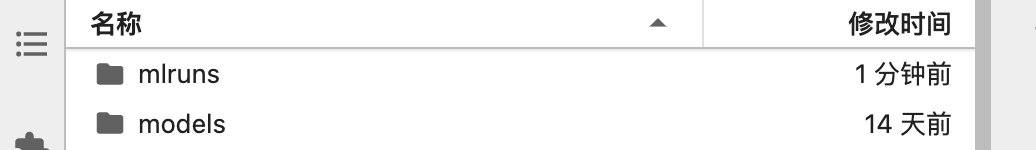



在以上的代码中R.start()只能与with搭配使用，其他情况下可以使用R.start_exp()来开始一个实验。R.start的参数有：

* experiment_name: 实验名称

* experiment_id: 实验id，默认为0开始自增的整数

* recorder_id: 如果已存在，且resume参数为True，则会根据指定的recoder_id，继续训练；如果resume为False，则会覆盖当前recorder_id目录下的记录。如果不存在，则在该实验下创建一个新的以该id为名称的目录。为空的时候，会随机生成一个新的recorder_id。

* resume：是否继续之前某个recorder_id的训练，与上面recorder_id参数配合使用

QlibRecorder在创建mlruns文件夹后，内部的文件夹创建规则是这样的：

* 每次运行以experient_id创建一个文件夹，当experient_id为指定时，默认以0开始的自增整数作为文件夹名称。
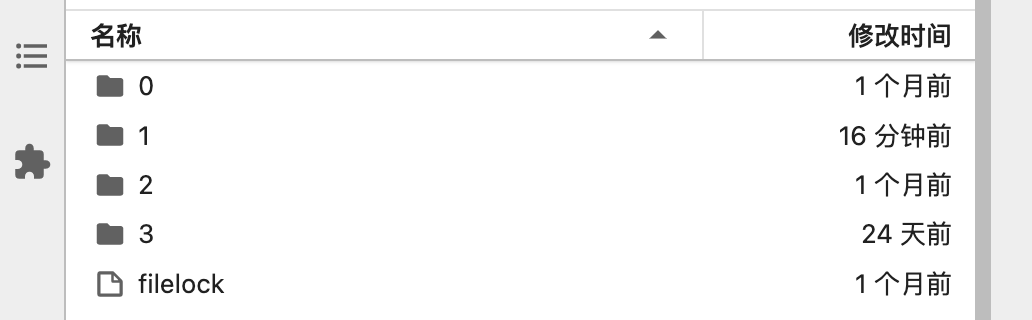

* 每个子文件夹表示一个实验，一个实验内部可以有多次实验，以recorder_id命名文件夹

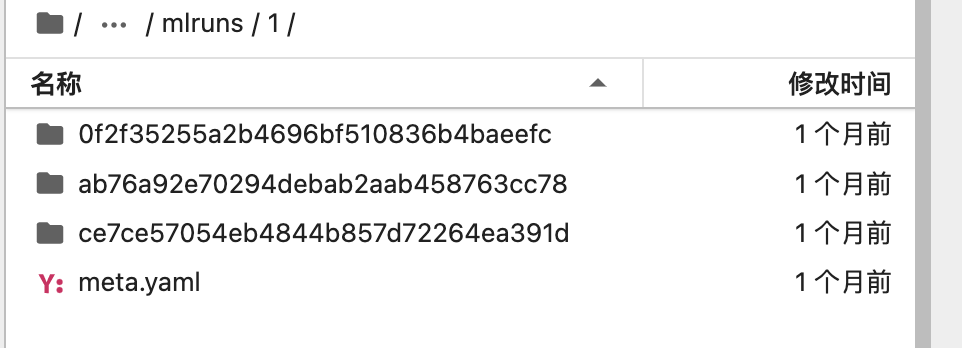

* 每个实验文件夹内的meta.yaml记录了该实验的experiment_id\name等信息

## Record Template

模型训练完之后的一些分析，可以通过Record Template来完成，正如上面的这些代码，完成了预测到策略分析的过程：

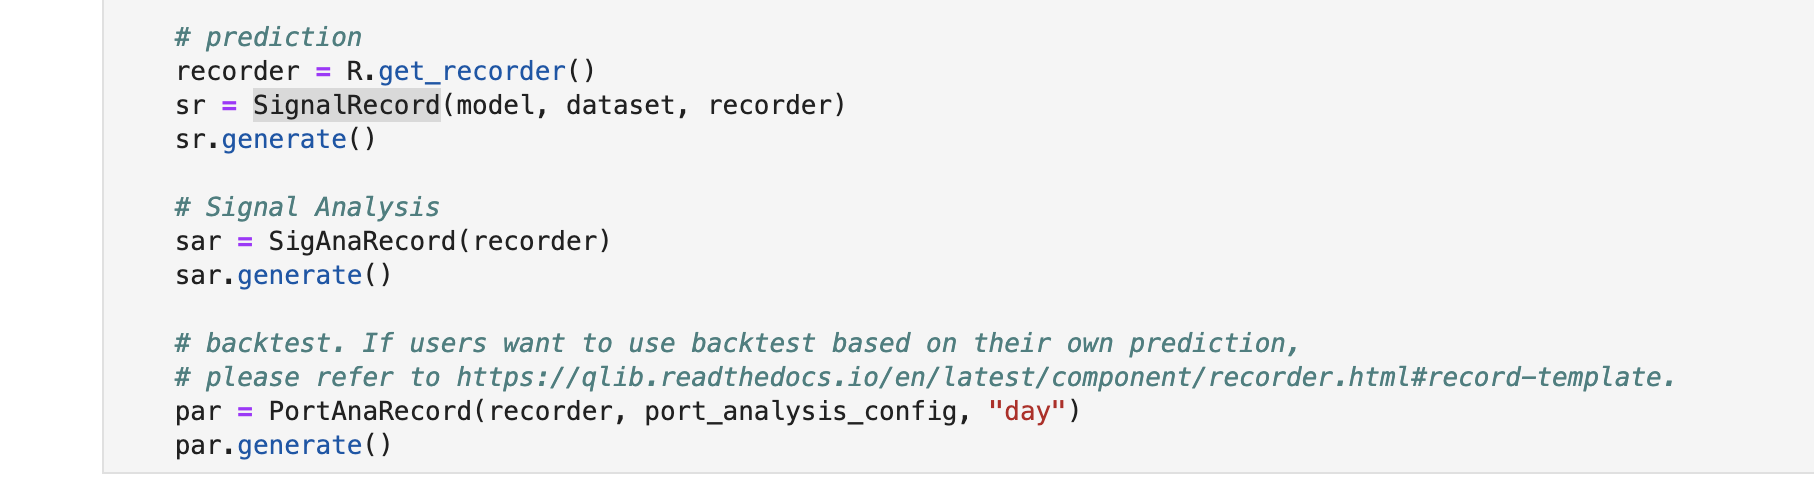

Record Template说白了就是把一些分析的逻辑，及分析结果的存储写在一个类里面进行实现，使得过程可重复，易管理保存。和我们之前介绍的实现自我定义的一些特征集（上文的MyFeatureSet）有类似的目的。我们只要看一下SigAnaRecord的源码就明白了：
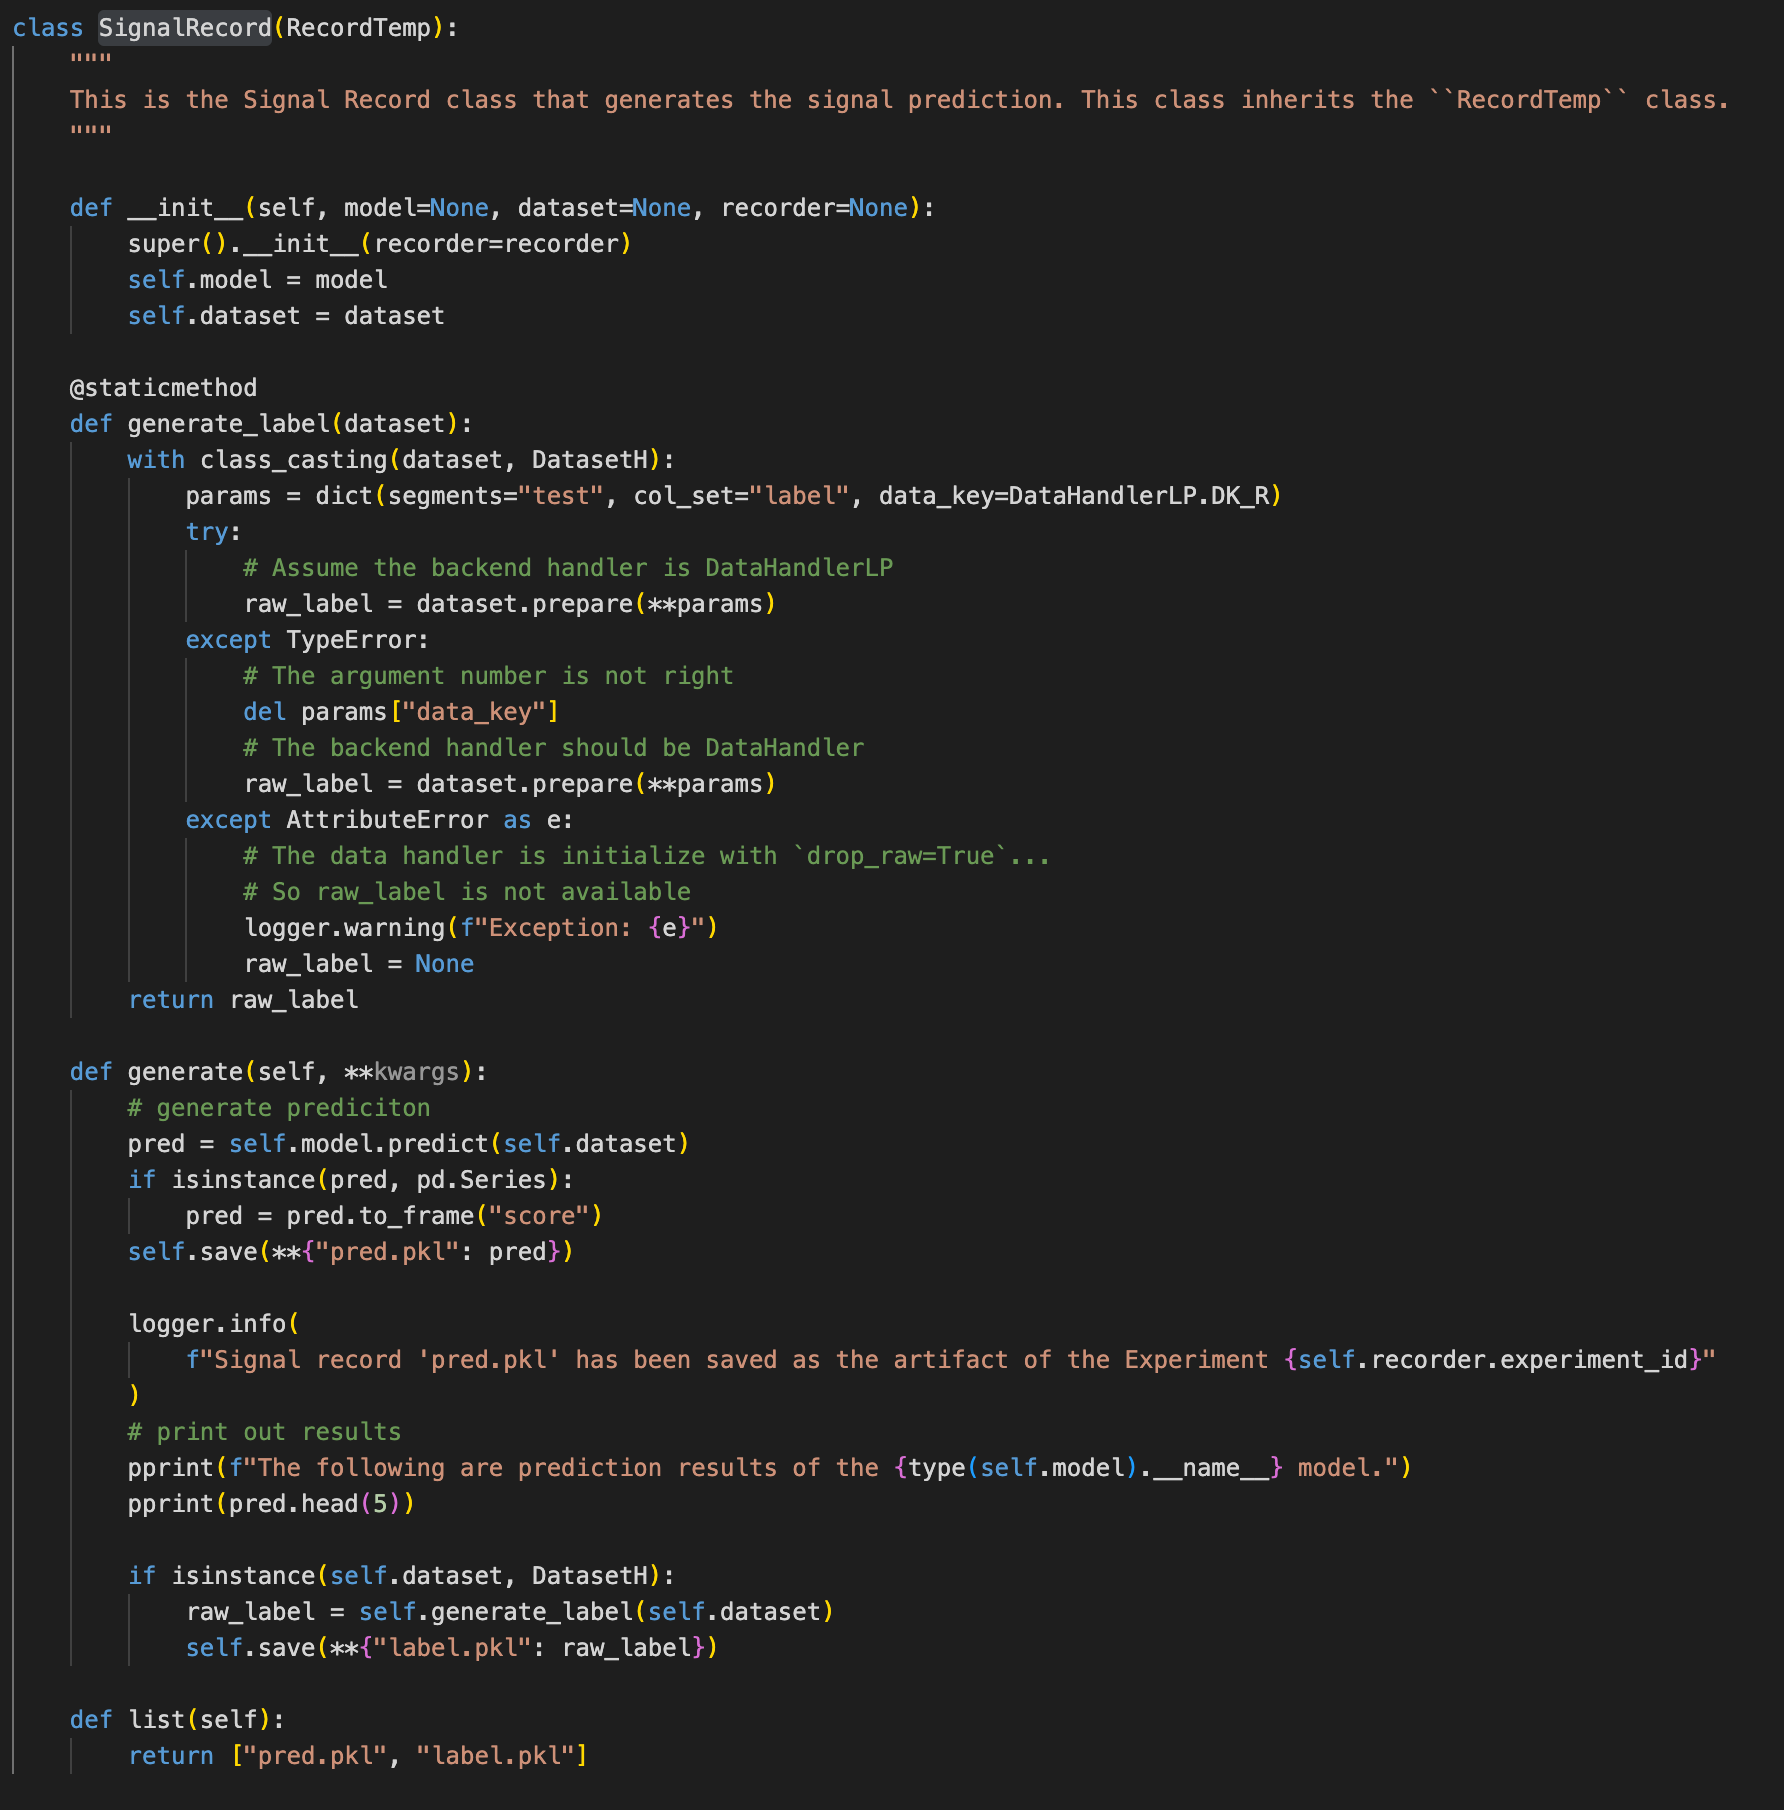

可以，看出以上代码中，generate方法就是实现了：
* 根据训练好的模型生成预测pred，并保存在pickle文件中
* 获取了测试集的label，保存在pickle文件中

# 总结

结合这三次的分享，大家对于qlib的官方案例qlib/example/workflow_by_code.py应该能够完全明白了。下次我们看一下介绍模型结果到策略回测的实现。

## 附录：如何使用Tensorboard查看模型结构

In [12]:
from qlib.contrib.model.pytorch_alstm_ts import ALSTMModel
from torch.utils.tensorboard import SummaryWriter
import torch


# 生成传入模型的样例数据
sample_data = torch.randn(2,20,6) # [batch, seq_len, d_feat]
alstm = ALSTMModel()

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('./runs/qlib_model')
writer.add_graph(alstm, sample_data)

writer.close()

# 在终端中运行(当前文件夹)以下命令，会有如下输出，然后再在浏览器打开localhost:6006
# tensorboard --logdir='./runs'

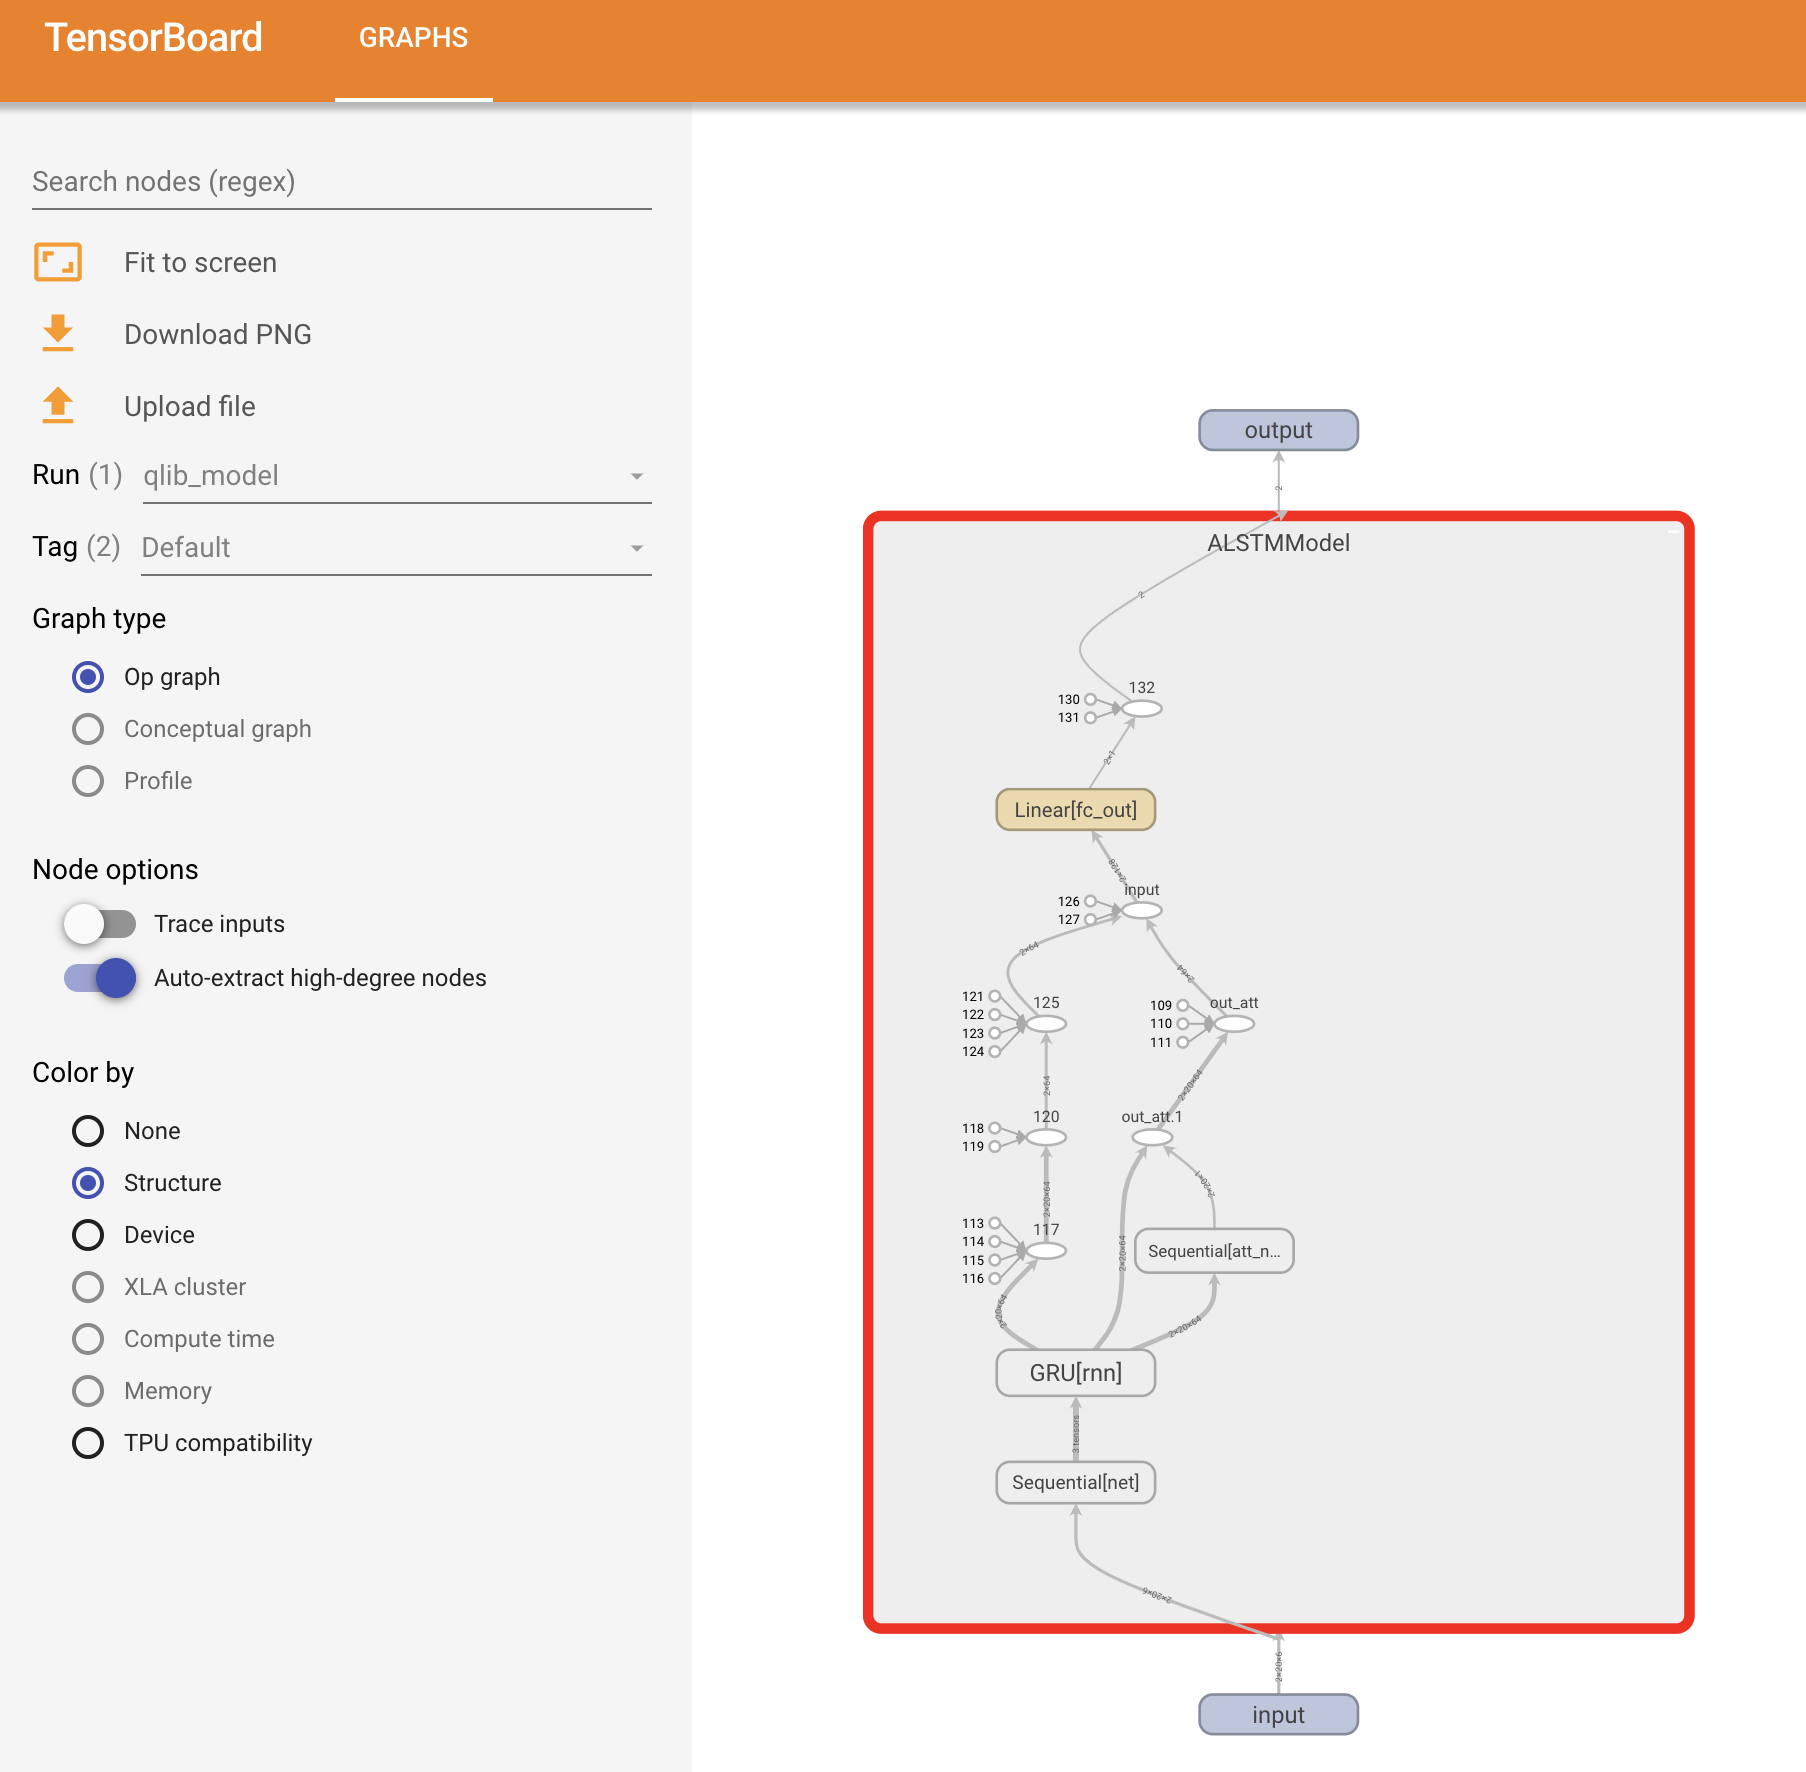